# Imports and Environment Load

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from dotenv import load_dotenv
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sqlalchemy.exc import SQLAlchemyError
import sys
import logging
import cx_Oracle

In [32]:
sys.path.append(os.path.abspath("../src"))

# Set seaborn style

In [33]:
sns.set(style="whitegrid")

# Load environment variables

In [34]:
load_dotenv()

True

# Import Custom Modules

In [35]:
from oracle_db_manager import OracleDBManager

# SentimentAnalyzer Class

In [36]:
class SentimentAnalyzer:
    def analyze_sentiment(self, text):
        try:
            blob = TextBlob(str(text))
            polarity = blob.sentiment.polarity
            sentiment = 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
            return sentiment, polarity
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return 'neutral', 0.0

    def analyze_dataframe(self, df, text_col='review_text'):
        df['sentiment'], df['polarity'] = zip(*df[text_col].apply(self.analyze_sentiment))
        return df

# InsightGenerator Class

In [37]:
class InsightGenerator:
    def __init__(self, df):
        self.df = df

    def top_keywords(self, sentiment_type='positive', n=10):
        texts = self.df[self.df['sentiment'] == sentiment_type]['review_text'].str.lower()
        all_words = ' '.join(texts).split()
        stopwords = set(STOPWORDS)
        filtered = [w for w in all_words if w not in stopwords and len(w) > 3]
        return Counter(filtered).most_common(n)

    def average_rating_by_bank(self):
        return self.df.groupby('bank_name')['rating'].mean().sort_values(ascending=False)

    def sentiment_counts_by_bank(self):
        return self.df.groupby(['bank_name', 'sentiment']).size().unstack().fillna(0)

    def sentiment_trends(self):
        df = self.df.copy()
        df['month'] = pd.to_datetime(df['review_date']).dt.to_period('M').astype(str)
        return df.groupby(['bank_name', 'month'])['polarity'].mean().unstack(level=0)


In [38]:
class Visualizer:
    def __init__(self, output_dir='outputs'):
        self.output_dir = output_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def plot_rating_distribution(self, df):
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x='rating', hue='bank_name', multiple='dodge', bins=5)
        plt.title('Rating Distribution by Bank')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'rating_distribution.png'))
        plt.show() # <--- ADDED: Display the plot
        plt.close() # <--- KEPT: Close the figure in memory after displaying/saving

    def plot_sentiment_trends(self, trend_df):
        plt.figure(figsize=(12, 6))
        for bank_name in trend_df.columns:
            if pd.api.types.is_numeric_dtype(trend_df[bank_name]):
                sns.lineplot(data=trend_df[bank_name], label=bank_name, marker='o')

        plt.title('Sentiment Trends Over Time')
        plt.xlabel('Date')
        plt.ylabel('Average Sentiment Score')
        plt.legend(title='Bank')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'sentiment_trends.png'))
        plt.show() # <--- ADDED: Display the plot
        plt.close() # <--- KEPT: Close the figure in memory after displaying/saving

    def plot_keyword_cloud(self, df):
        unique_banks = df['bank_name'].unique()

        for bank in unique_banks:
            text = ' '.join(df[df['bank_name'] == bank]['review_text'].dropna().astype(str).str.lower())

            if text:
                wordcloud = WordCloud(width=800, height=400, background_color='white',
                                      stopwords=STOPWORDS, colormap='viridis').generate(text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f'Keyword Cloud for {bank}')
                plt.savefig(os.path.join(self.output_dir, f'keyword_cloud_{bank.replace(" ", "_")}.png'))
                plt.show() # <--- ADDED: Display the plot
                plt.close() # <--- KEPT: Close the figure in memory after displaying/saving
            else:
                print(f"No review text found for {bank} to generate a word cloud.")

In [39]:
class ReviewAnalysisPipeline:
    def __init__(self):
        self.user = os.getenv("ORACLE_USER")
        self.password = os.getenv("ORACLE_PASSWORD")
        self.dsn = os.getenv("ORACLE_DSN")
        self.connection_mode = cx_Oracle.SYSDBA if self.user and self.user.upper() == "SYS" else None
        self.db = OracleDBManager(user=self.user, password=self.password, dsn=self.dsn, mode=self.connection_mode)

    def run(self):
        try:
            logging.info(f"Connecting to database as {self.user}")
            self.db.connect()
            self.db.create_tables()
            
            # Load CSV
            try:
                source_df = pd.read_csv('../data/bank_reviews_clean.csv')
                logging.info(f"Loaded {source_df.shape[0]} rows from source CSV.")
            except FileNotFoundError:
                logging.error("Source CSV file 'bank_reviews.csv' not found. Please provide your data file.")
                sys.exit(1)
                return
            
        # --- 
            # Insert Banks and Reviews
            bank_names = source_df['bank'].unique()
            bank_id_map = self.db.insert_banks(bank_names)
            self.db.insert_reviews(source_df, bank_id_map)

            # Fetch Data for Analysis
            query = """
                SELECT b.name AS bank_name, r.review_text, r.rating, r.review_date, r.source
                FROM reviews r
                JOIN banks b ON r.bank_id = b.id
                WHERE b.name IN ('Commercial Bank of Ethiopia', 'Bank of Abyssinia', 'Dashen Bank')
            """
            df = self.db.fetch_dataframe(query)

            # Rename columns if needed
            df.columns = [col.lower() for col in df.columns]

            if df.empty:
                logging.warning("No data found for analysis.")
                return

            # Sentiment Analysis
            analyzer = SentimentAnalyzer()
            df = analyzer.analyze_dataframe(df)

            # Insights
            insights = InsightGenerator(df)
            print("Top Positive Keywords:", insights.top_keywords('positive'))
            print("Top Negative Keywords:", insights.top_keywords('negative'))
            print("\nAverage Rating by Bank:\n", insights.average_rating_by_bank())
            print("\nSentiment Count by Bank:\n", insights.sentiment_counts_by_bank())

            # Visualizations
            viz = Visualizer()
            viz.plot_rating_distribution(df)
            viz.plot_sentiment_trends(insights.sentiment_trends())
            viz.plot_keyword_cloud(df)

        except Exception as e:
            logging.error(f"Pipeline error: {e}", exc_info=True)
        finally:
            self.db.close()
            logging.info("Closed database connection.")


# ----------------- Run the Pipeline  ----------------- 

Attempting to connect to DSN: localhost:1521/xepdb1 as user: FINTECH_APP_USER
Database connection established.
Banks table already exists, skipping creation.
Reviews table already exists, skipping creation.
Inserted/updated 3 banks.
Inserted 1106 reviews.


d:\AI Mastery\Project\Fintech-App-Review-Analysis\src\oracle_db_manager.py:71: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


Top Positive Keywords: [('good', 594), ('dashen', 534), ('best', 510), ('bank', 450), ('banking', 444), ('super', 444), ('easy', 330), ('mobile', 252), ('amazing', 246), ('fast', 240)]
Top Negative Keywords: [('worst', 156), ('bank', 132), ('banking', 120), ('even', 96), ('app.', 84), ('mobile', 78), ('slow', 78), ('work', 72), ('working', 66), ('make', 54)]

Average Rating by Bank:
 bank_name
Dashen Bank                    4.408971
Commercial Bank of Ethiopia    4.162921
Bank of Abyssinia              2.706199
Name: rating, dtype: float64

Sentiment Count by Bank:
 sentiment                    negative  neutral  positive
bank_name                                               
Bank of Abyssinia                 516      906       804
Commercial Bank of Ethiopia       156      714      1266
Dashen Bank                       174      468      1632


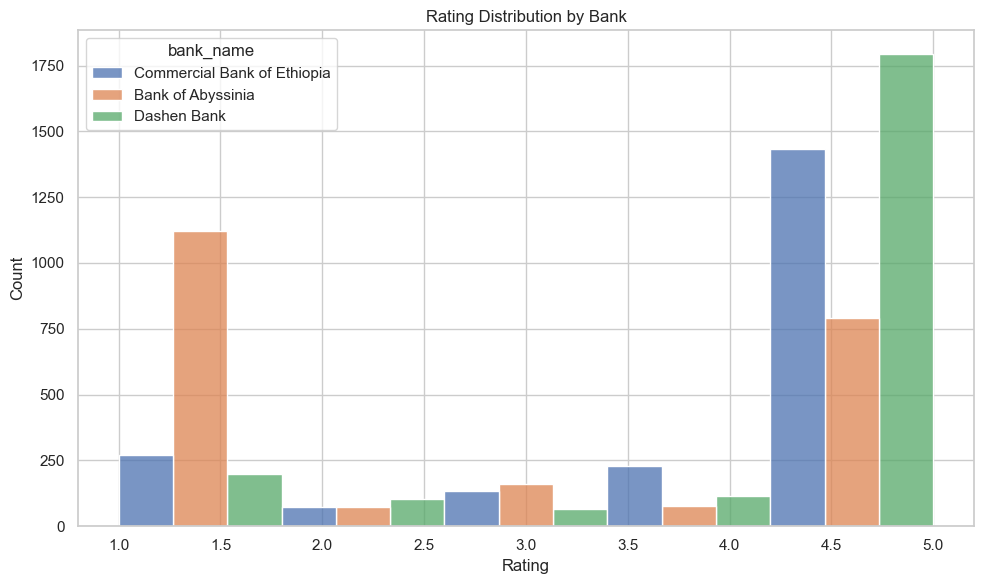

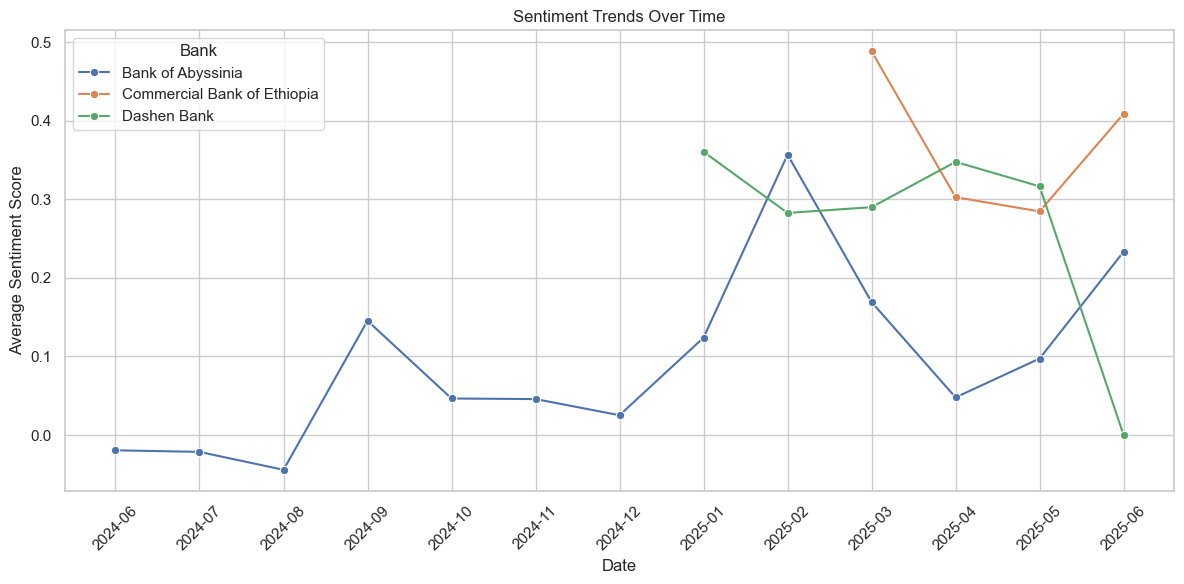

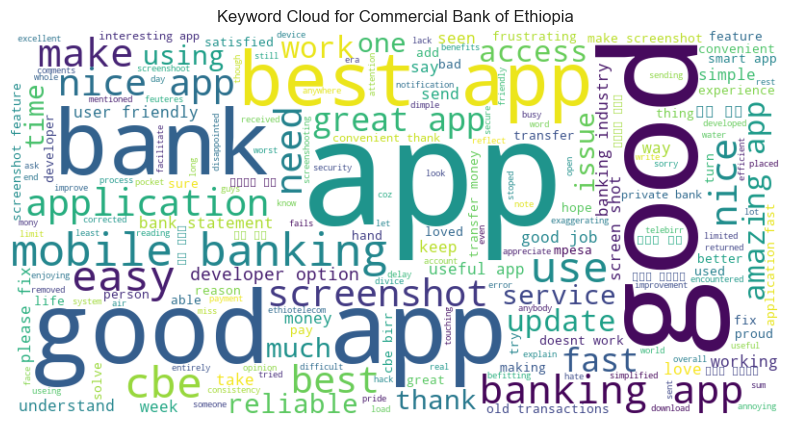

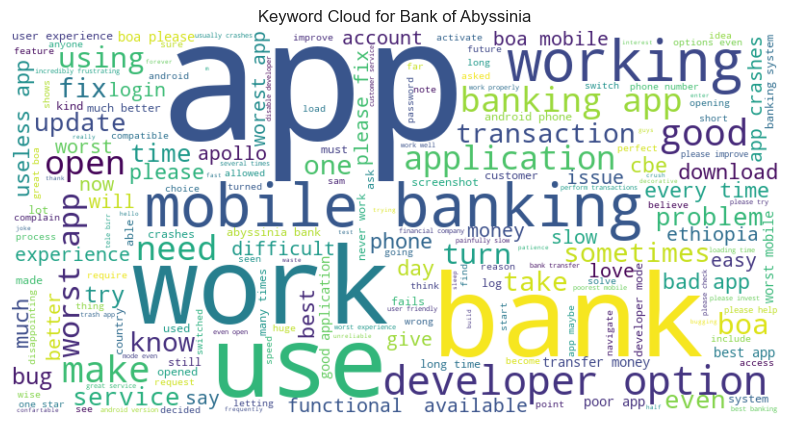

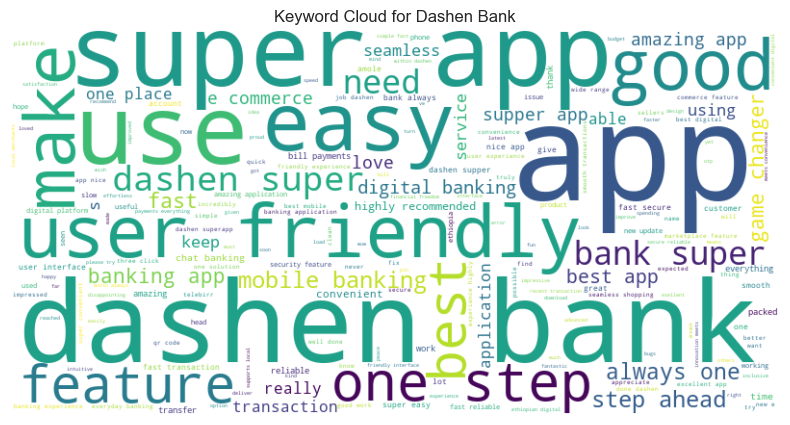

Cursor closed.
Database connection closed.


In [40]:
pipeline = ReviewAnalysisPipeline()
pipeline.run()